In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import math
from matplotlib.patches import Rectangle, Circle
from textwrap import wrap
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
from sklearn.metrics.pairwise import euclidean_distances

import sys
sys.path.append('/Users/cbulacan/cbula-git/kaggle')

from local_libs.viz import CoverageVisualizer
from local_libs.coverage_area_analyzer import CoverageAreaAnalyzer

"""
master_input.parquet
master_output.parquet
play_level.parquet
player_analysis.parquet
spatial_features.parquet
supplementary.parquet
trajectories.parquet
"""
base_dir = "../consolidated_data/"

# Sample Plot
# if frame_id == 10:
#     plt.scatter(x, y, marker='o')
#     plt.xlim(0, 120)
#     plt.ylim(0, 53.3)

In [3]:
play_keys = ['game_id', 'play_id']
player_keys = play_keys + ['nfl_id']
player_dtls = ['player_name', 'player_position', 'player_side', 'player_role']
player_dtls_ext = player_dtls + ['player_to_predict', 'player_height', 'player_weight', 'player_birth_date', 'num_frames_output']
player_mvmt = ['frame_id', 'x', 'y']
player_mvmt_ext = player_mvmt + ['play_direction', 's', 'a', 'dir', 'o']
input_cols = player_keys + player_dtls_ext + player_mvmt_ext + ['absolute_yardline_number', 'ball_land_x', 'ball_land_y', 'week']
output_cols = player_keys + player_mvmt

# field extents
xmin, ymin = 0, 0
xmax, ymax = 120, 53.3

input_df = pd.read_parquet(f'{base_dir}/master_input.parquet')
supp_df = pd.read_parquet(f'{base_dir}/supplementary.parquet')
output_df = pd.read_parquet(f'{base_dir}/master_output.parquet')

In [4]:
supp_df[['team_coverage_man_zone', 'team_coverage_type']].groupby(['team_coverage_man_zone', 'team_coverage_type']).size()

team_coverage_man_zone  team_coverage_type
MAN_COVERAGE            COVER_0_MAN            781
                        COVER_1_MAN           4108
                        COVER_2_MAN            332
ZONE_COVERAGE           COVER_2_ZONE          2518
                        COVER_3_ZONE          5664
                        COVER_4_ZONE          2860
                        COVER_6_ZONE          1693
                        PREVENT                 48
dtype: int64

In [5]:
# let's first consider 1 play
frame_keys = player_keys + ['frame_id']
game_id, play_id = 2023090700, 1679
play_df = input_df.loc[((input_df['game_id'] == game_id) & (input_df['play_id'] == play_id))]
offense = play_df.loc[(play_df['player_side'] == 'Offense'), player_keys + player_dtls + player_mvmt_ext]
defense = play_df.loc[(play_df['player_side'] == 'Defense'), player_keys + player_dtls + player_mvmt_ext]

In [6]:
grouped = defense.sort_values(['nfl_id', 'frame_id']).groupby('nfl_id')
num_input_frames = max(defense['frame_id'])
positions = {}

for nfl_id, nfl_df in grouped:
    positions[nfl_id] = list(zip(nfl_df['x'], nfl_df['y'], nfl_df['o']))

In [7]:
# 44888
oplayers = offense[['nfl_id', 'player_name']].drop_duplicates()
oplayers

,nfl_id,player_name
7769,41325,Jerick McKinnon
7800,46213,Justin Watson
7831,53591,Noah Gray
7862,54519,Skyy Moore
7893,44822,Patrick Mahomes
7924,46243,Marquez Valdes-Scantling


In [8]:
dplayers = defense[['nfl_id', 'player_name']].drop_duplicates()
dplayers

,nfl_id,player_name
7552,44888,Alex Anzalone
7583,55910,Brian Branch
7614,47888,C.J. Gardner-Johnson
7645,44906,Cameron Sutton
7676,53953,Jerry Jacobs
7707,54562,Kerby Joseph
7738,54653,Malcolm Rodriguez


In [10]:
ogrouped = offense.sort_values(['nfl_id', 'frame_id']).groupby('nfl_id')
num_input_frames = max(defense['frame_id'])
off_positions = {}

for nfl_id, nfl_df in ogrouped:
    off_positions[nfl_id] = list(zip(nfl_df['x'], nfl_df['y'], nfl_df['o']))

In [11]:
def euclidean(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

coverage = {}

for def_id, def_df in grouped:
    coverage[def_id] = {}
    for i in range(1, num_input_frames + 1):
        x2 = def_df.loc[def_df['frame_id'] == i, ['x']].iloc[0]['x']
        y2 = def_df.loc[def_df['frame_id'] == i, ['y']].iloc[0]['y']
        def_pos = [x2, y2]
        for off_id, off_df in ogrouped:
            if off_id not in coverage[def_id]:
                coverage[def_id][off_id] = []
            x1 = off_df.loc[off_df['frame_id'] == i, ['x']].iloc[0]['x']
            y1 = off_df.loc[off_df['frame_id'] == i, ['y']].iloc[0]['y']
            off_pos = [x1, y1]
            dist = euclidean(def_pos, off_pos)
            coverage[def_id][off_id].append(dist)

In [13]:
import itertools

coverage_distance = {}

for def_id in coverage:
    for off_id in coverage[def_id]:
        if def_id not in coverage_distance:
            coverage_distance[def_id] = {}
        coverage_distance[def_id][off_id] = [b - a for a, b in itertools.pairwise(coverage[def_id][off_id])]

In [118]:
for dp in coverage:
    for op in coverage[dp]:
        m = min(coverage[dp][op])
        if m < 10:
            print(dp, op, min(coverage[dp][op]))

44888 41325 9.340369371711162
44888 46213 1.5754681843820248
44906 46243 7.191835648845155
44906 54519 7.196499148891766
47888 46213 6.283247567938098
47888 46243 6.759474831671468
53953 46213 8.320606949015199
54562 46213 2.8155638866841604
54653 46243 2.241985726984006
54653 53591 7.70483614361785
54653 54519 7.96216679051626
55910 46243 4.562071897723669
55910 53591 7.627581530209952
55910 54519 1.3452509059651272


In [24]:
analyzer = CoverageAreaAnalyzer(play_df)
visualizer = CoverageVisualizer(analyzer)



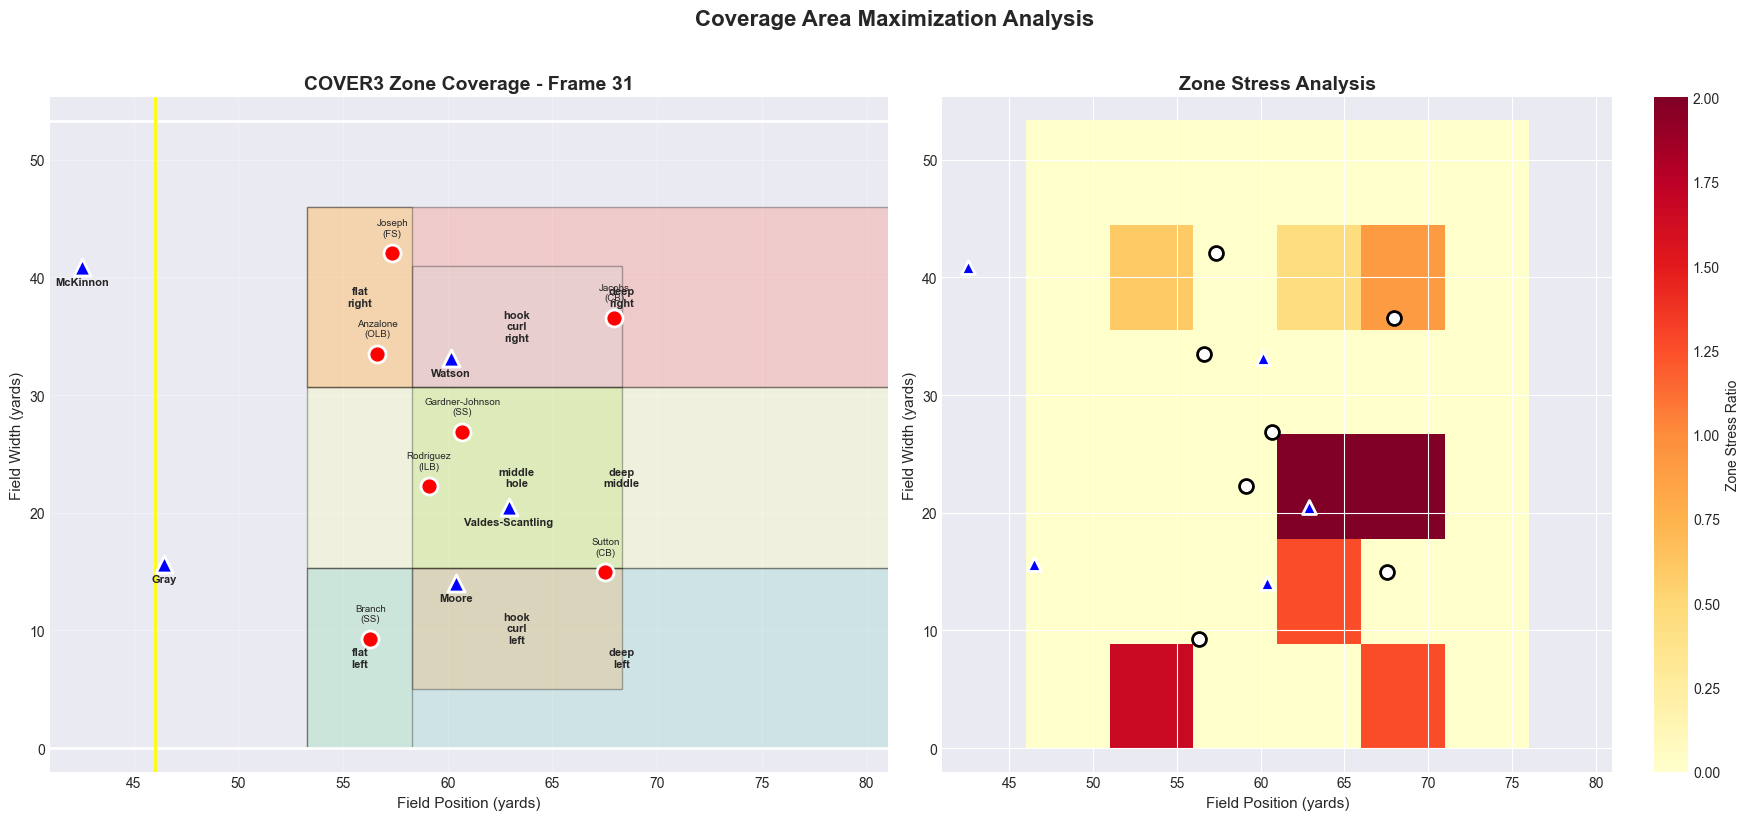

In [25]:
fig1 = visualizer.plot_zone_coverage_map(31, 'cover3')


In [26]:
analyzer.calculate_zone_stress(31)

{'deep_left': {'defenders': 1,
  'threats': 1,
  'total_threat_level': 1.251,
  'stress_ratio': 1.251,
  'threat_details': [{'player': 'Skyy Moore',
    'threat_level': 1.251,
    'in_zone': np.True_,
    'speed': 8.34,
    'position': (60.38, 14.04)}],
  'defender_details': [{'nfl_id': 44906,
    'name': 'Cameron Sutton',
    'position': 'CB',
    'x': 67.52,
    'y': 14.94}]},
 'deep_middle': {'defenders': 0,
  'threats': 3,
  'total_threat_level': 2.8229999999999995,
  'stress_ratio': 5.645999999999999,
  'threat_details': [{'player': 'Justin Watson',
    'threat_level': 0.6,
    'in_zone': np.False_,
    'speed': 6.0,
    'position': (60.15, 33.13)},
   {'player': 'Skyy Moore',
    'threat_level': 0.834,
    'in_zone': np.False_,
    'speed': 8.34,
    'position': (60.38, 14.04)},
   {'player': 'Marquez Valdes-Scantling',
    'threat_level': 1.3889999999999998,
    'in_zone': np.True_,
    'speed': 9.26,
    'position': (62.91, 20.46)}],
  'defender_details': []},
 'deep_right': {'